# animating dimension reduction of spike times as point processes
Tim Tyree<br>
2.20.2021

In [1]:
#automate the boring stuff
from lib.getterdone import *
# import h5py,json,os

### compute the point process feature vectors for one trial

In [130]:
#search_for_filename
# input_file_name=search_for_file()
#preparsed json data is deserialized
# input_file_name=f"{nb_dir}/Data/Archie/spike_times_trial_80.json"
input_file_name=f"{nb_dir}/Data/Archie/spike_times_trial_20.json"
# input_file_name=f"{nb_dir}/Data/Archie/spike_times_trial_4.json"

#manual data has an ugly dtype
# input_file_name='/Users/timothytyree/Documents/GitHub/neurophysics/notebooks/Data/SRT_CollabData/SortedData_Manual/catTempPopStorage_full.mat'
#early autogen data
# input_file_name='/Users/timothytyree/Documents/GitHub/neurophysics/notebooks/Data/SRT_CollabData/SortedData_AutoGen/Archie_SRT_Set226_subset1_201020_142509_UnitStorage.mat'


In [131]:
with open(input_file_name) as f:
    data_raw = json.load(f)
# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}
type(data_raw)

dict

In [132]:
# #initialize a list of length N=number of neurons
# N=len(list(data_raw.keys()))
# X=np.full(N,np.nan,dtype=np.float64)
# #functionally compute the time since last spike time for a given time for each neuron
# t=0
# for n,key in enumerate(data_raw.keys()):
#     spikes=np.array(data_raw[key],np.float64)
#     spikes=spikes[spikes<t]
#     if not spikes.shape[0]==0:
#         lag=t-spikes[-1]
#         X[n]=lag #time since last spike in the nth neuron
#         # X[n]=1/lag #rate since last spike in the nth neuron

In [133]:
#input neuron id
nid_self=20#0
l=nid_self
key_self=list(data_raw.keys())[l]
times_self=np.array(data_raw[key_self],np.float64)
M=times_self.shape[0]

In [134]:
# #represent spiketime trial for 1 neuron as a point process in terms of an 1 x m x n numpy array
N=len(list(data_raw.keys()))
arr = np.full([M, N], np.nan)

#initialize a list of length N=number of neurons
# X=np.full(N,np.nan,dtype=np.float64)
#functionally compute the time since last spike time for a given time for each neuron
for m,t in enumerate(times_self):
    for n,key in enumerate(data_raw.keys()):
        spikes=np.array(data_raw[key],np.float64)
        spikes=spikes[spikes<t]
        if not spikes.shape[0]==0:
            lag=t-spikes[-1]
            arr[m,n]=lag #time since last spike in the nth neuron
            # X[n]=1/lag #rate since last spike in the nth neuron

In [135]:
#TODO: find the biggest subsquare with no nan values
#GOAL: have no nan values in arr
#find the fraction of True for each column
boo_neurons_keep=~np.isnan(arr)[-1,:]
for n in range(N):
    earliest_time_thresh=-1
    if boo_neurons_keep[n]:
        boo=np.isnan(arr)[:,n]
        frac=sum(boo)/boo.shape[0]
        #earliest time of nonnan value for given neuron is less than earliest_time_thresh
        boo_neurons_keep[n]=times_self[~boo][0]<earliest_time_thresh

In [136]:
boo_times_keep=times_self>earliest_time_thresh
Mnew=sum(boo_times_keep)
Nnew=sum(boo_neurons_keep)
arrnew=arr[boo_times_keep][:,boo_neurons_keep]
#assert there are no remaining nan values
assert (not np.isnan(arrnew).any())

In [137]:
data=arrnew
data.shape

(74, 188)

In [138]:
#classify spikes as before/after the stimulus
spike_times=np.array(data_raw[f"{nid_self}"])

t_stim=.15#~150ms for stimulus to reach the neurons in the hippocampus
boo_before_stim=spike_times<t_stim
boo_after_stim=~boo_before_stim

#classify spikes as before or after stim
target_names=[r'before',r'after']
target=boo_before_stim*0+boo_after_stim*1
target=target[boo_times_keep]

#TODO(later): represent spiketime trial for all neurons as an array of point processes in terms of an l x m x n numpy array

## for a set of trials, compute the feature vectors
6.7.2021

In [2]:
input_dir=f"{nb_dir}/Data/Archie/"+'Archie_SRT_Set212_Subset1_200520_165716_pointProcess_20_compressed.npz'
dataset=np.load(input_dir)

In [53]:
#computelag feature vector
data=dataset['data']
target=dataset['target']
trialnum_values=dataset['trialnum_values']
spike_times=dataset['t_values']
target_names=[r'dubious',r'decisive',r'reflective']

In [ ]:
# #compute rate of change of lag feature vector
# DT_values=np.diff(dataset['t_values'])
# # DT_thresh=10#1
# # boo=np.abs(DT_values)<DT_thresh
# boo=np.diff(dataset['trialnum_values'])==0
# DX_values=np.diff(dataset['data'],axis=0)
# # Y_values=np.divide(DX_values,DT_values,axis=0)
# Y_values=np.stack([DX_values[:,j]/DT_values for j in range(DX_values.shape[1])],axis=1)
# print(Y_values.shape)
# data=Y_values[boo,:]
# spike_times=dataset['t_values'][1:][boo]
# target=dataset['target'][1:][boo]
# trialnum_values=dataset['trialnum_values'][1:][boo]
# target_names=[r'dubious',r'decisive',r'reflective']

In [131]:
#TODO: compute moving average lag feature vector
data=dataset['data']
target=dataset['target']
trialnum_values=dataset['trialnum_values']
spike_times=dataset['t_values']
target_names=[r'dubious',r'decisive',r'reflective']
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
x_lst=[]
navg=5
for x in data.T:
    x_lst.append(moving_average(x, w=navg))
data=np.stack(x_lst).T
target=moving_average(dataset['target'], w=navg)
trialnum_values=moving_average(dataset['trialnum_values'], w=navg)
spike_times=moving_average(dataset['t_values'], w=navg)
boo=np.diff(moving_average(dataset['trialnum_values'], w=navg))==0
data=data[1:][boo,:]
spike_times=spike_times[1:][boo]
target=dataset['target'][2+int((navg+1)/4):-int((navg+1)/4)-1][boo]
trialnum_values=trialnum_values[1:][boo]

In [ ]:
#select a particular temporal phase
# boo=target==0 #dubious
# boo=target==1 #decisive
boo=target==2 #reflective
data=data[boo]
target=trialnum_values[boo]

In [ ]:
#TODO(later): compute rate of change of rate feature vector
#TODO: try concatenating feature vectors

# visualize different parameter settings with umap
- Results for ~250 spikes (neuron 0, trial 4, archie)
    - spike event patterns can be observed as lines in data=arrnew
    - self-consistent in time
    - large angles at beginning of umap clustere
    - umap clusters separate at stimulus onset
- Results for 23 spikes (neuron 7, trial 40, archie)
    - spike event patterns can be observed somewhat.  Data may be too sparse...
-

In [38]:
# #load example data
# from sklearn.datasets import load_digits
# digits = load_digits()
# data = digits.data
# data.shape

In [39]:
# #TODO(later): Represent point process of spike times as an 8x8 bit image (under some reasonable normalization that is consistent accross samples)
# index=212
# plt.subplots(figsize=(1,1))
# plt.imshow(data[index].reshape((8,8)),cmap='gray')
# plt.axis('off')
# plt.show()

In [108]:
# Ignore UserWarnings
import warnings
warnings.simplefilter('ignore', UserWarning)
# from umap import UMAP

In [127]:
def tween(e1, e2, n_frames=20):
    for i in range(5):
        yield e1
    for i in range(n_frames):
        alpha = i / float(n_frames - 1)
        yield (1 - alpha) * e1 + alpha * e2
    for i in range(5):
        yield(e2)
    return

In [128]:
def generate_frame_data(data, metric, arg_name='n_neighbors', arg_list=[], **kwargs):
    result = []
    es = []
    for arg in arg_list:
        kwargs = {arg_name:arg}
        if len(es) > 0:
            es.append(UMAP(init=es[-1], negative_sample_rate=3,metric=metric, **kwargs).fit_transform(data))
        else:
            es.append(UMAP(negative_sample_rate=3,metric=metric, **kwargs).fit_transform(data))
        
    for e1, e2 in zip(es[:-1], es[1:]):
        result.extend(list(tween(e1, e2)))
        
    return result

In [129]:
def create_animation(frame_data, spike_times, arg_name='n_neighbors', arg_list=[],**kwargs):
    fig, ax = plt.subplots()
    all_data = np.vstack(frame_data)
    frame_bounds = (all_data[:, 0].min() * 1.1, 
                    all_data[:, 0].max() * 1.1,
                    all_data[:, 1].min() * 1.1, 
                    all_data[:, 1].max() * 1.1)
    ax.set_xlim(frame_bounds[0], frame_bounds[1])
    ax.set_ylim(frame_bounds[2], frame_bounds[3])
    
    #size by class and color by time 

# #     #size by class and color by time
#     spike_times=np.array(data_raw[f"{nid_self}"])
#     st=spike_times[boo_times_keep]
#     s_values=target*100+5
# #     s_values=20*(st-st[0])/(st[-1]-st[0])
#     points = ax.scatter(frame_data[0][:, 0], frame_data[0][:, 1], s=s_values, c=st, cmap='Blues', 
#                         animated=True)
    
    
    #color by time
    spike_times=np.array(data_raw[f"{nid_self}"])
    points = ax.scatter(frame_data[0][:, 0], frame_data[0][:, 1], s=50, c=spike_times, cmap='Blues', 
                        animated=True)

#     color by class and spike times
#         points = ax.scatter(frame_data[0][:, 0], frame_data[0][:, 1], s=s_values, c=target, cmap='Spectral', 
#                         animated=True)

    #color by class and size by time
# #     st=spike_times[boo_times_keep]
#     st=spike_times
# #     s_values=80*(st-st[0])/(st[-1]-st[0])
#     s_values=88+0*(st-st[0])/(st[-1]-st[0])
#     points = ax.scatter(frame_data[0][:, 0], frame_data[0][:, 1], s=s_values, c=target, cmap='viridis', 
#                         animated=True,alpha=0.7)
    n=len(target_names)
    #Colorbar
    cbar = fig.colorbar(
        points,
        cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.25),
        orientation="vertical",
        values=np.arange(n),
        boundaries=np.arange(n+1)-0.5,
        ticks=np.arange(n),
        drawedges=True,
    )
    cbar.ax.yaxis.set_ticklabels(target_names, fontsize=18)
    
    title = ax.set_title('', fontsize=24)
    ax.set_xticks([])
    ax.set_yticks([])

    def init():
        points.set_offsets(frame_data[0])
        arg = arg_list[0]
        arg_str = f'{arg:.3f}' if isinstance(arg, float) else f'{arg}'
        title.set_text(f'{arg_name}={arg_str}')
#         title.set_text(f'UMAP with {arg_name}={arg_str}')
        return (points,)

    def animate(i):
        points.set_offsets(frame_data[i])
        if (i + 15) % 30 == 0:
            arg = arg_list[(i + 15) // 30]
            arg_str = f'{arg:.3f}' if isinstance(arg, float) else f'{arg}'
            title.set_text(f'{arg_name}={arg_str}')
#             title.set_text(f'UMAP with {arg_name}={arg_str}')
        return (points,)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frame_data), interval=20, blit=True)
    plt.close()
    return anim

In [130]:
def animate_param(data, arg_name='n_neighbors', arg_list=[],**kwargs):
    frame_data = generate_frame_data(data, arg_name=arg_name, arg_list=arg_list, **kwargs)
    return create_animation(frame_data, spike_times, arg_name, arg_list)

In [117]:
#set the style/make the ticks small and the figsize fixed
sns.set(style='white', rc={'figure.figsize':(14, 12), 'animation.html': 'html5'})

In [132]:
# #select a particular phase
# boo=target==2 #reflective
# data=data[boo]
# target=trialnum_values[boo]

NameError: name 'data_raw' is not defined

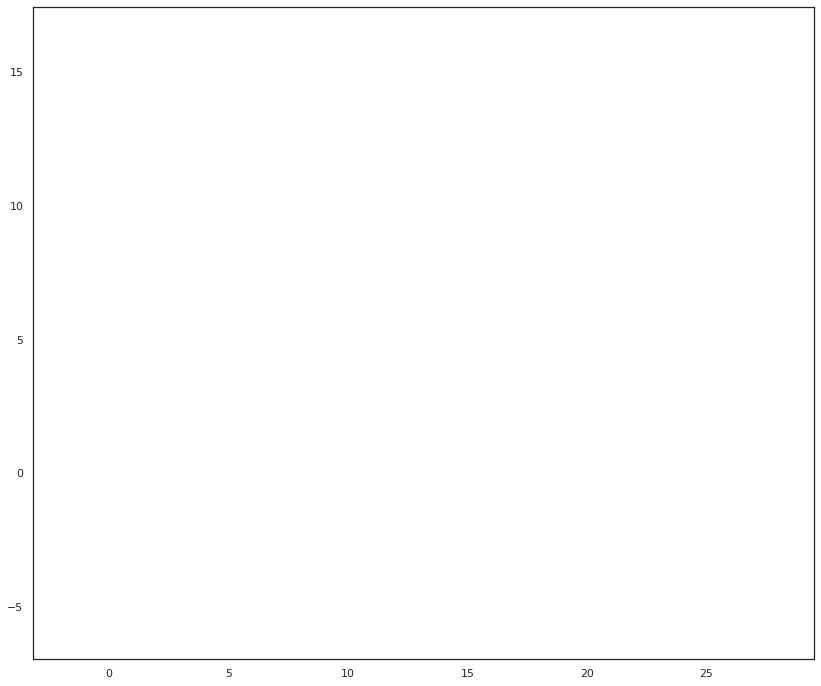

In [133]:
# data=arrnew #naive spike dwell times did yield seperable connection types
# data=1/arrnew  #naive spike rates did not yield seperable connection types
# metric='euclidean'
metric='mahalanobis'
# metric='cosine'
# metric='correlation'
# metric='hellinger'
metric='wminkowski'

# output_metric='euclidean'
# output_metric='hyperboloid'
output_metric='gaussian_energy'
kwargs={
    'metric':metric,
    'output_metric':output_metric
}
animate_param(data, 'n_neighbors', [3, 4, 5, 7, 10, 15, 25, 50, 100],**kwargs)

In [ ]:
animate_param(data, 'min_dist', [0.0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.9],**kwargs)

In [ ]:
animate_param(data, 'local_connectivity', [0.1, 0.2, 0.5, 1, 2, 10],**kwargs)

In [ ]:
animate_param(data, 'set_op_mix_ratio', np.linspace(0.0, 1.0, 10),**kwargs)

## more ideas of what to do with umap and various distance metrics...

In [ ]:
%%time
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)

#embed interactive video toys in your documents!  
# http://localhost:8888/notebooks/umap/notebooks/Document%20embedding%20using%20UMAP.ipynb

- I would expect the Mahalanobis distance to be the natural measure of gaussian distributions embedded in $\mathbb{R}^{+N}$.
- Hellinger distance measures the distance between two probability distributions
- Consider XX[i] as the true distribution of times since each neuron has fired conditioned on the ith neuron having just fired? 
    - Question: what is the hellinger distance between the distributions __before vs. after__ the stimulus onset at time t=0?  
    - Question: what is the hellinger distance between the max liklihood estimate for XX[i] and the uniform distribution UU[i] (as a null hypothesis?)


In [136]:
#for a discussion of the following distance measures, see
# http://localhost:8888/notebooks/umap/notebooks/UMAP%20usage%20and%20parameters.ipynb

### ``metric``

The final UMAP parameter we will be considering in this notebook is the ``metric`` parameter. This controls how distance is computed in the ambient space of the input data. By default UMAP supports a wide variety of metrics, including:

**Minkowski style metrics**
* euclidean
* manhattan
* chebyshev
* minkowski

**Miscellaneous spatial metrics**
* canberra
* braycurtis
* haversine

**Normalized spatial metrics**
* mahalanobis
* wminkowski
* seuclidean

**Angular and correlation metrics**
* cosine
* correlation

**Metrics for binary data**
* hamming
* jaccard
* dice
* russelrao
* kulsinski
* rogerstanimoto
* sokalmichener
* sokalsneath
* yule

Any of which can be specified by setting ``metric='<metric name>'``; for example to use cosine distance as the metric you would use ``metric='cosine'``.

UMAP offers more than this however -- it supports custom user defined metrics as long as those metrics can be compiled in ``nopython`` mode by numba. For this notebook we will be looking at such custom metrics. To define such metrics we'll need numba ...

## TODO: apply naïve umap to a point process representation of one trial.
- TODO: look for a convenient interface to explore .mat files or .hdf5 files.  MATLAB?  Then, how to import to python?  Save to .hdf5 file?

- TODO: import 1 trial of spiketimes as a numpy array
    - N = number of neurons
- TODO: for the i^th neuron, compute the time since last firing for each neuron, X[i]
    - X[i][j,k] = the latest time since the k^th neuron has fired at the time the j^th time the i^th neuron has fired
- TODO: compute at least one interesting UMAP .mp4 for each neuron, i=1,...,N


and then,
- TODO: find two trials that are a match/mismatch pair, 

In [135]:
pip install hdf5plugin

     |████████████████████████████████| 829 kB 3.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Classification of spikes as caused by in-house connections or out-of-house connections 
- by counting the number of spikes within a bin of reasonable lags, (1ms - 20ms)
- Result: you can't easily/clearly distinguish neurons as stimulating vs not stimulating a given neuron

In [25]:
# index 0: spike id
# index 1: neuron id

data.shape

(23, 169)

In [26]:
#time window that defines cofiring
tau_min=0.001#sec
tau_max=0.02#sec

#percentage thresholds to classify cofiring/anticofiring
pthresh_upper=70
pthresh_lower=10

frc_lst=[]
for nid in range(data.shape[1]):
    boo=(data[:,nid]>tau_min)&(data[:,nid]<tau_max)
    percent_within_time_window=100*sum(boo)/boo.size
    frc_lst.append(percent_within_time_window)

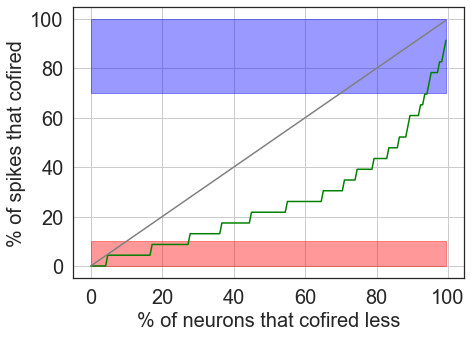

In [27]:
fontsize=20
plt.subplots(figsize=(7,5))
x_values=np.array(sorted(range(data.shape[1])))/data.shape[1]*100
y_values=np.array(sorted(frc_lst))
plt.plot(x_values,y_values,c='green')
plt.plot(x_values,x_values,c='grey')
plt.fill_between(x_values,pthresh_upper+0.*x_values,100+0.*x_values,color='blue',alpha=0.4)
plt.fill_between(x_values,0.+0.*x_values,pthresh_lower+0.*x_values,color='red',alpha=0.4)
plt.ylabel('% of spikes that cofired',fontsize=fontsize)
plt.xlabel('% of neurons that cofired less',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.grid()
plt.show()

- TODO: make function that makes data from data_raw for a given input_neuron_id
- TODO: make ^this line plot for all neurons and the average neuron for 1 trial

- TODO: scatter plot of most cofiring and least cofiring neurons

In [191]:
nid_values=np.array(sorted(range(data.shape[1])))
boo=np.array(frc_lst)>pthresh_upper
boo_remaining = ~boo
cofiring_neuron_indicies=nid_values[boo]

boo=np.array(frc_lst)<pthresh_lower
boo_remaining &= ~boo
antifiring_neuron_indicies=nid_values[boo]

remaining_neuron_indicies=nid_values[boo_remaining]

print(cofiring_neuron_indicies.shape)
print(antifiring_neuron_indicies.shape)
print(remaining_neuron_indicies.shape)

(7,)
(52,)
(133,)


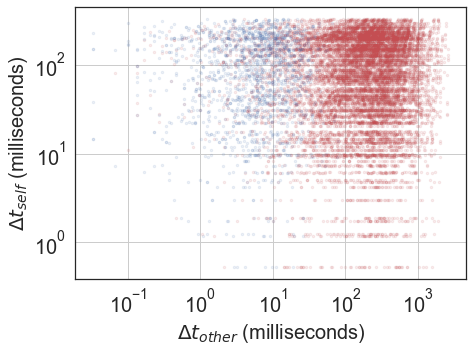

In [192]:
fontsize=20
plt.subplots(figsize=(7,5))
# for nid_other in remaining_neuron_indicies:#cofiring is unclear
#     y_values=data[:,nid]*10**3#time between spikes for self
#     x_values=data[:,nid_other]*10**3#time since given neuron has fired
#     plt.scatter(x_values,y_values,c='gray',alpha=0.01,s=3,label='_Hidden')
for nid_other in antifiring_neuron_indicies:#antifiring is unclear
    y_values=data[:,nid]*10**3#time between spikes for self
    x_values=data[:,nid_other]*10**3#time since given neuron has fired
    plt.scatter(x_values,y_values,c='r',alpha=0.1,s=6,label='antifiring')
for nid_other in cofiring_neuron_indicies:#cofiring is unclear
    y_values=data[:,nid]*10**3#time between spikes for self
    x_values=data[:,nid_other]*10**3#time since given neuron has fired
    plt.scatter(x_values,y_values,c='b',alpha=0.1,s=6,label='cofiring')
plt.ylabel(r'$\Delta t_{self}$ (milliseconds)',fontsize=fontsize)
plt.xlabel(r'$\Delta t_{other}$ (milliseconds)',fontsize=fontsize)
plt.yscale('log')
plt.xscale('log')
# plt.legend(fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.grid()
plt.show()

# classify each spike on the basis of how many cofiring neurons are present

In [270]:
#time window that defines cofiring
tau_min=0.001#sec
tau_max=0.02#sec
boo_cofiring=(data>tau_min)&(data<tau_max)

#percentage thresholds to classify cofiring/anticofiring
pthresh_upper=30
pthresh_lower=17
# frc_lst=[]
# for nid in range(data.shape[1]):
#     boo=(data[:,nid]>tau_min)&(data[:,nid]<tau_max)
#     percent_within_time_window=100*sum(boo)/boo.size
#     frc_lst.append(percent_within_time_window)

number_cofiring_neurons=np.sum(boo_cofiring,axis=1)
spike_index=np.arange(0,number_cofiring_neurons.shape[0])

#classify spikes as in-house or out-of-house
percent_of_neurons_cofiring=number_cofiring_neurons*100/data.shape[1]
boo_remaining=(percent_of_neurons_cofiring>pthresh_lower)&(percent_of_neurons_cofiring<pthresh_upper)
boo_out_of_house=(percent_of_neurons_cofiring<=pthresh_lower)
boo_in_house=(percent_of_neurons_cofiring>=pthresh_upper)
target_names=['out-of-house','remaining','in-house']
target=boo_in_house*2+boo_remaining*1+boo_out_of_house*0

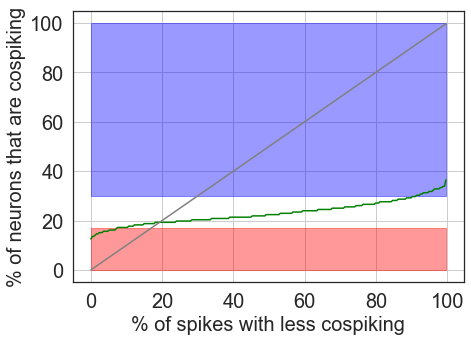

In [273]:
fontsize=20
plt.subplots(figsize=(7,5))
x_values=np.array(sorted(range(data.shape[0])))/data.shape[0]*100
y_values=np.array(sorted(number_cofiring_neurons))*100/data.shape[1]
plt.plot(x_values,y_values,c='green')
plt.plot(x_values,x_values,c='grey')
plt.fill_between(x_values,pthresh_upper+0.*x_values,100+0.*x_values,color='blue',alpha=0.4)
plt.fill_between(x_values,0.+0.*x_values,pthresh_lower+0.*x_values,color='red',alpha=0.4)
plt.ylabel('% of neurons that are cospiking',fontsize=fontsize)
plt.xlabel('% of spikes with less cospiking',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.grid()
plt.show()

__Results__
- Blue=in-house spikes
- Red=out-of-house spikes
- between 15-40% of neurons recorded are cospiking for a given spike from a given neuron

__Methods__
- see above

In [264]:
#TODO: label each neuron as firing vs. cofiring

In [266]:
# #load example data
# from sklearn.datasets import load_digits
# digits = load_digits()
# dat = digits.data
# dat.shape

In [267]:
# digits.target

# histogram of lags of others

In [ ]:
    y_values=data[:,nid]*10**3#time between spikes for self
    x_values=data[:,nid_other]*10**3#time since given neuron has fired
    plt.scatter(x_values,y_values,c='r',alpha=0.1,s=6,label='antifiring')

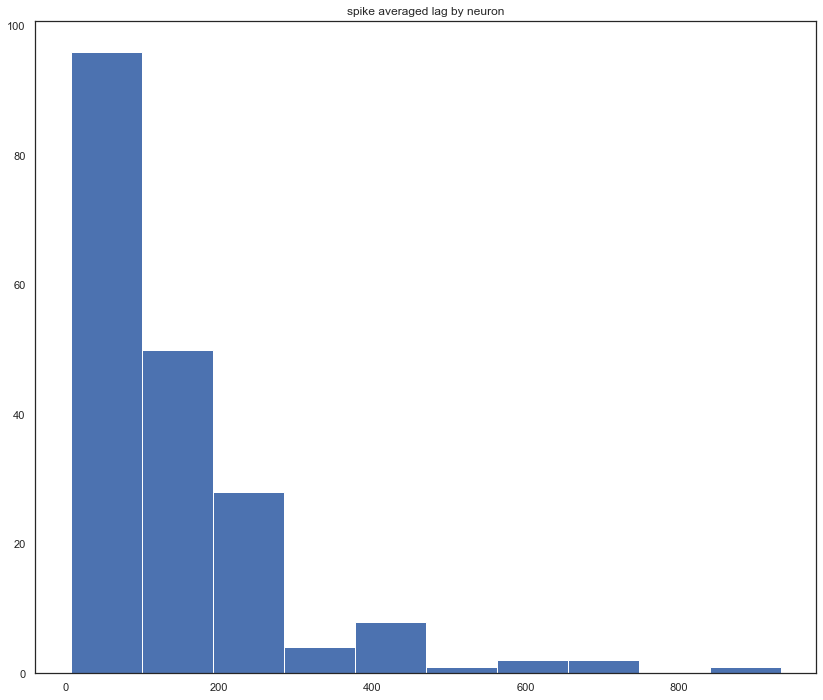

In [252]:
plt.hist(np.mean(data,axis=0)*10**3)
plt.title('spike averaged lag by neuron')
plt.show()

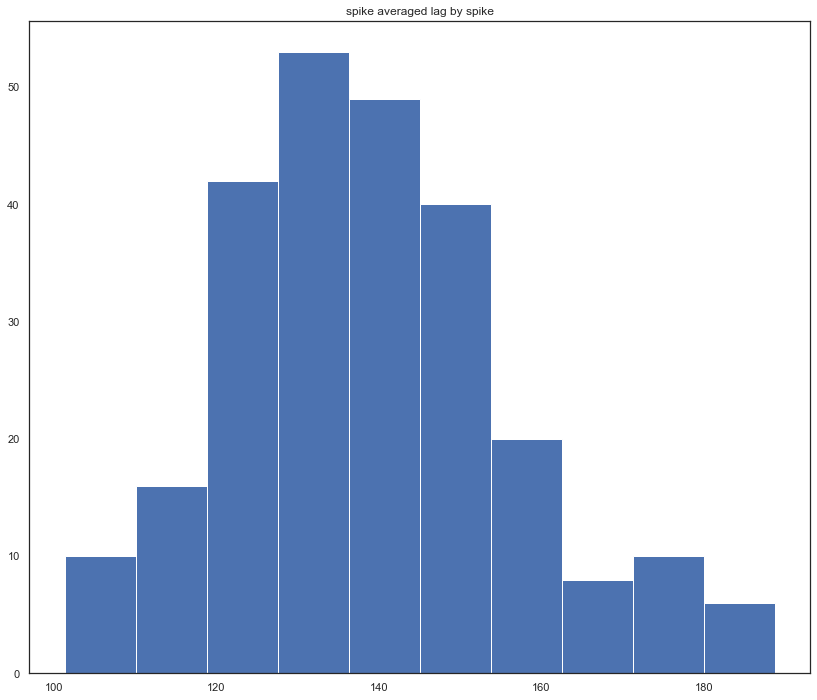

In [253]:
plt.hist(np.mean(data,axis=1)*10**3)
plt.title('spike averaged lag by spike')
plt.show()

# classify on the basis of being before/after the stimulus
__Result__
- before stimulus is cleanly separated from after stimulus

In [69]:
spike_times=np.array(data_raw[f"{nid_self}"])

t_stim=.15#~150ms for stimulus to reach the neurons in the hippocampus
boo_before_stim=spike_times<t_stim
boo_after_stim=~boo_before_stim

#classify spikes as before or after stim
target_names=[r'before',r'after']
target=boo_before_stim*0+boo_after_stim*1
target=target[boo_times_keep]

# classify spikes based on when they occured
__Result__
- spike event patterns are slowly varying in time
- TODO: umap the derivative of X versus time 
- TODO: compute the derivative of X versus time 

In [68]:
spike_times=np.array(data_raw[f"{nid_self}"])

t_stim=.15#~150ms for stimulus to reach the neurons in the hippocampus
t_part=1.+t_stim
boo_before=spike_times<t_stim
boo_after_1=(~boo_before_stim)&(spike_times<t_part)
boo_after_2=~boo_before_stim&(spike_times>=t_part)


#classify spikes as before or after stim
target_names=[r'before',r'just after', r'1 sec after']
target=boo_before*0+boo_after_1*1+boo_after_2*2
target=target[boo_times_keep]

# TODO: classify spikes based on the angle between them and a given token spike-delay pattern
- method option # 1: unsupervised heirarchical clustering
- method option # 2: look through the umap repo for how to take info out from umap

# TODO: classify spikes based on the value of the determinant of the outer product of the spike event
- -> This is a simple scalar measure of a markovian spike event pattern
- however, det appears always zero unless a weight matrix is used to represent connections... but everything is connected to everything...

In [335]:
det_lst=[]
for i in range(data.shape[0]):
    X=1/(data[i]*10**3)
    det_lst.append(np.linalg.det(np.outer(X.T,X)))

In [334]:
data.shape

(254, 192)

0.0

# Research Question: does the number of distinct  spike event patterns depend on whether the stimulus is a match mismatch?
- spike event patterns='markovian spike event patterns'?
- spike event patterns='attention heads'?

 # Research Question: do the jump times in a umap correspond to saccade jump times?
 - easy test given saccade times + ~150ms, does the attention switch

# Classifying spikes based on angular defect between consecutive spikes
__Result__
- large angular changes happen at the beginning of attention heads

In [456]:
#angle between X versus time
angle_lst=[]
for i in range(1,data.shape[0]):
    X_prv=data[i-1]
    X_cur=data[i]
    angle=180/np.pi*np.arccos(np.dot(X_prv,X_cur)/np.sqrt(np.dot(X_prv,X_prv)*np.dot(X_cur,X_cur)))#degrees
    angle_lst.append(angle)

In [457]:
#angular thresholds to classify changes in attention head
thresh_upper=32
# thresh_lower=18

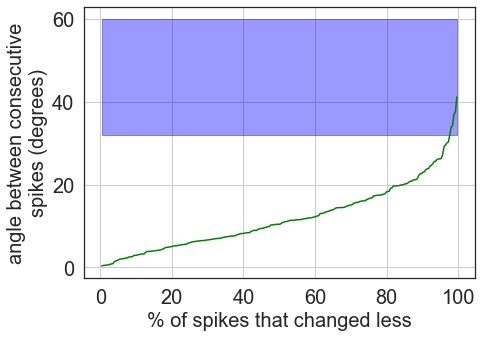

In [458]:
fontsize=20
plt.subplots(figsize=(7,5))
x_values=np.array(sorted(range(1,data.shape[0])))/data.shape[0]*100
y_values=np.array(sorted(angle_lst))
plt.plot(x_values,y_values,c='green')
# plt.plot(x_values,x_values,c='grey')
plt.fill_between(x_values,thresh_upper+0.*x_values,60+0.*x_values,color='blue',alpha=0.4)
# plt.fill_between(x_values,0.+0.*x_values,pthresh_lower+0.*x_values,color='red',alpha=0.4)
plt.ylabel('angle between consecutive\nspikes (degrees)',fontsize=fontsize)
plt.xlabel('% of spikes that changed less',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.grid()
plt.show()

In [459]:

boo_remaining=(percent_of_neurons_cofiring>pthresh_lower)&(percent_of_neurons_cofiring<pthresh_upper)

boo_remaining|=True

boo_remaining[1:]&=np.array(angle_lst)<thresh_upper
boo_changers=~boo_remaining

print(sum(boo_changers))

#classify spikes as angular changers or not
target_names=['changers','remaining']
target=boo_changers*1+boo_remaining*0

5


# TODO: tensorflow the spike times of the given as a function of all other neuronal spike times

# TODO: validate results by repeating notebook with different neurons, different trials, and different monkeys

# TODO(then): label spike times by cluster index, where cluster index is defined by "crawls" between spike event patterns in steps of stepsize, $\Delta Y>0$ in UMAP1,2 space (or UMAP1,2,3 space)
- TODO: test for consistency of attention heads versus time between neurons for a given trial
- TODO: compute mean feature vector projection for each attention head
- if neuron index is consistent between trials
    - TODO: compute angles between ^thesee projections between trials.

# TODO(first): test whether these jumps in attention are at saccade times